<a href="https://colab.research.google.com/github/odie2630463/pyro_tutorial/blob/master/Gaussian_Mixture_Model(Moon).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pyro-ppl

In [0]:
import numpy as np
import torch
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
from pyro import sample , poutine , plate , param
from pyro.contrib.autoguide import AutoDiagonalNormal,AutoDelta,AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
pyro.enable_validation(True)

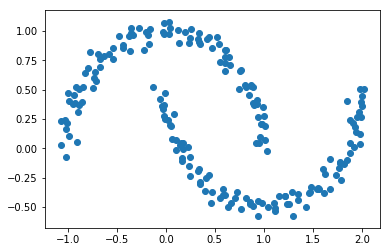

In [0]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

## Define model and training

In [0]:
K = 16

@config_enumerate
def model(obs, len):
  weight = param('weight' , torch.ones(K) / K , constraints.unit_interval)
  
  with plate('component', K):
    locs = sample('locs', dist.Normal(torch.zeros(2), torch.ones(2)).to_event(1))
    scales = sample('scales', dist.LogNormal(torch.zeros(2), torch.ones(2)).to_event(1))
  
  with plate('local', len):
    z = sample('z', dist.Categorical(weight))
    x = sample('x', dist.Normal(locs[z], scales[z]).to_event(1) ,obs=obs)
    return x

In [0]:
guide = AutoDelta(poutine.block(model, expose=["locs","scales"]))

In [0]:
pyro.clear_param_store()
elbo = TraceEnum_ELBO()
optim = pyro.optim.Adam({'lr': 1e-2})
svi = SVI(model, guide, optim, loss=elbo)

In [0]:
for _ in range(1000):
  loss = svi.step(torch.tensor(Xmoon).float() , len(Xmoon))

print(loss)

192.144775390625


## Sampling from model

In [0]:
guide_trace = poutine.trace(guide).get_trace(Xmoon, len(Xmoon))
sample = poutine.replay(model, guide_trace)(None ,1000).detach().numpy()

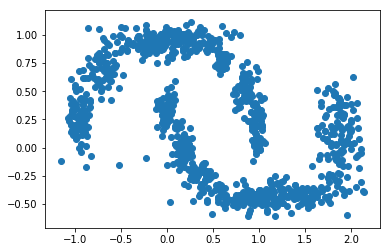

In [0]:
plt.scatter(sample[:, 0], sample[:, 1])

## Show cluster result

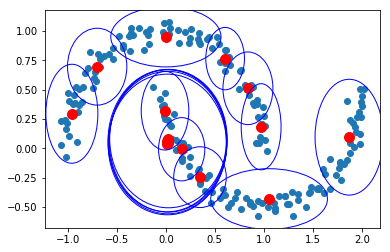

In [0]:
fig = plt.figure()
ax = fig.gca()

plt.scatter(Xmoon[:,0] , Xmoon[:,1])

locs_ = pyro.get_param_store()['auto_locs'].detach().numpy()
scales_ = pyro.get_param_store()['auto_scales'].detach().numpy()

for i in range(K):
  plt.scatter(locs_[i,0], locs_[i,1], 99, c='red')
  cov = np.zeros((2,2))
  cov[0,0] = scales_[i,0]
  cov[1,1] = scales_[i,1]
  lam, v = np.linalg.eig(cov)
  lam = np.sqrt(lam)
  ell = Ellipse(xy=(locs_[i,0], locs_[i,1]),      
                width=lam[0]*2, height=lam[1]*2,
                angle=np.rad2deg(np.arccos(v[0, 0])),
                color='blue')
  ell.set_facecolor('none')
  ax.add_artist(ell)